**IMPORTING NECESSARY LYBRARIES OF PYTHON**


In [5]:
import os
import numpy as np
import json
import tensorflow as tf
from tensorflow.keras import layers, callbacks, Sequential
from pydub import AudioSegment, effects
import librosa
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras import callbacks 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import h5py
from tensorflow.keras.models import model_from_json
from collections import Counter
import noisereduce as nr
from librosa import display   
import IPython.display as ipd 
from scipy.ndimage import uniform_filter1d
import librosa.display
from pydub import AudioSegment, effects
import time

**CREATING A MODEL and training it with RAVDESS dataset**


In [15]:


# Initialize a list to store sample lengths
sample_lengths = []

# Define the path to the folder containing audio files
folder_path = r"C:\Users\rocky\OneDrive\Desktop\Desktop\INTERN\Audio_Song_Actors_01-24"

# List of common audio file extensions
audio_extensions = {'.wav', '.mp3', '.flac'}

# Walk through the directory to access all files
for subdir, dirs, files in os.walk(folder_path):
    for file in files:
        # Construct the full file path
        file_path = os.path.join(subdir, file)
        # Get the file extension
        ext = os.path.splitext(file)[1].lower()
        
        # Check if the file has an audio extension
        if ext in audio_extensions:
            try:
                # Load the audio file
                x, sr = librosa.load(file_path, sr=None)
                # Trim silence from the beginning and end
                xt, index = librosa.effects.trim(x, top_db=30)
                # Append the length of the trimmed audio to the list
                sample_lengths.append(len(xt))
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")

# Find and print the maximum sample length
max_sample_length = np.max(sample_lengths) if sample_lengths else None
print('Maximum sample length:', max_sample_length)


Maximum sample length: 243200


In [16]:

tic = time.perf_counter()

# Initialize data lists
rms = []
zcr = []
mfcc = []
emotions = []

# Initialize variables
total_length = max_sample_length  # Ensure this is defined
frame_length = 2048
hop_length = 512
valid_extensions = ['.wav']  # Add other audio formats if needed

# Debugging output
file_count = 0

for subdir, dirs, files in os.walk(folder_path):
    for file in files:
        if any(file.lower().endswith(ext) for ext in valid_extensions):
            file_path = os.path.join(subdir, file)
            try:
                print(f"Processing file: {file_path}")
                file_count += 1
                
                # Fetch the sample rate.
                _, sr = librosa.load(path=file_path, sr=None)  # sr (the sample rate) is used for librosa's MFCCs. '_' is irrelevant.
                
                # Load the audio file.
                rawsound = AudioSegment.from_file(file_path)
                
                # Normalize the audio to +5.0 dBFS.
                normalizedsound = effects.normalize(rawsound, headroom=0)
                
                # Transform the normalized audio to np.array of samples.
                normal_x = np.array(normalizedsound.get_array_of_samples(), dtype='float32')
                
                # Trim silence from the beginning and the end.
                xt, index = librosa.effects.trim(normal_x, top_db=30)
                
                # Pad for duration equalization.
                padded_x = np.pad(xt, (0, total_length - len(xt)), 'constant')
                
                # Noise reduction.
                final_x = nr.reduce_noise(y=padded_x, sr=sr)

                # Features extraction
                f1 = librosa.feature.rms(y=final_x, frame_length=frame_length, hop_length=hop_length)  # Energy - Root Mean Square   
                f2 = librosa.feature.zero_crossing_rate(y=final_x, frame_length=frame_length, hop_length=hop_length, center=True)  # ZCR      
                f3 = librosa.feature.mfcc(y=final_x, sr=sr, n_mfcc=13, hop_length=hop_length)  # MFCC

                # Emotion extraction from RAVDESS dataset
                name = file[6:8]  # Extracting emotion label directly from the filename

                # Filling the data lists  
                rms.append(f1)
                zcr.append(f2)
                mfcc.append(f3)
                emotions.append(emotionfix(name)) 

            except Exception as e:
                print(f"Error processing file {file_path}: {e}")

# Final debug output
print(f"Total files processed: {file_count}")

toc = time.perf_counter()
print(f"Running time: {(toc - tic)/60:0.4f} minutes")


Processing file: C:\Users\rocky\OneDrive\Desktop\Desktop\INTERN\Audio_Song_Actors_01-24\Actor_01\03-02-01-01-01-01-01.wav
Processing file: C:\Users\rocky\OneDrive\Desktop\Desktop\INTERN\Audio_Song_Actors_01-24\Actor_01\03-02-01-01-01-02-01.wav
Processing file: C:\Users\rocky\OneDrive\Desktop\Desktop\INTERN\Audio_Song_Actors_01-24\Actor_01\03-02-01-01-02-01-01.wav
Processing file: C:\Users\rocky\OneDrive\Desktop\Desktop\INTERN\Audio_Song_Actors_01-24\Actor_01\03-02-01-01-02-02-01.wav
Processing file: C:\Users\rocky\OneDrive\Desktop\Desktop\INTERN\Audio_Song_Actors_01-24\Actor_01\03-02-02-01-01-01-01.wav
Processing file: C:\Users\rocky\OneDrive\Desktop\Desktop\INTERN\Audio_Song_Actors_01-24\Actor_01\03-02-02-01-01-02-01.wav
Processing file: C:\Users\rocky\OneDrive\Desktop\Desktop\INTERN\Audio_Song_Actors_01-24\Actor_01\03-02-02-01-02-01-01.wav
Processing file: C:\Users\rocky\OneDrive\Desktop\Desktop\INTERN\Audio_Song_Actors_01-24\Actor_01\03-02-02-01-02-02-01.wav
Processing file: C:\User

In [17]:
# Adjusting features shape to the 3D format: (batch, timesteps, feature)

f_rms = np.asarray(rms).astype('float32')
f_rms = np.swapaxes(f_rms,1,2)
f_zcr = np.asarray(zcr).astype('float32')
f_zcr = np.swapaxes(f_zcr,1,2)
f_mfccs = np.asarray(mfcc).astype('float32')
f_mfccs = np.swapaxes(f_mfccs,1,2)

print('ZCR shape:',f_zcr.shape)
print('RMS shape:',f_rms.shape)
print('MFCCs shape:',f_mfccs.shape)

ZCR shape: (1011, 476, 1)
RMS shape: (1011, 476, 1)
MFCCs shape: (1011, 476, 13)


In [18]:
# Concatenating all features to 'X' variable.
X = np.concatenate((f_zcr, f_rms, f_mfccs), axis=2)

# Preparing 'Y' as a 2D shaped variable.
Y = np.asarray(emotions).astype('int8')
Y = np.expand_dims(Y, axis=1)

In [282]:


x_data = X.tolist() 
x_path = r"C:\Users\rocky\OneDrive\Desktop\Desktop\INTERN\Audio_Song_Actors_01-24\Actor_01\X_datanew.json"  # FILE SAVE PATH

# Open the file in write mode
with open(x_path, 'w') as file:
    json.dump(x_data, file)  # Write JSON data to the file

y_data = Y.tolist() 
y_path = r"C:\Users\rocky\OneDrive\Desktop\Desktop\INTERN\Audio_Song_Actors_01-24\Actor_01\Y_datanew.json"  # FILE SAVE PATH

# Open the file in write mode
with open(y_path, 'w') as file:
    json.dump(y_data, file)  # Write JSON data to the file


In [284]:


x_path = r"C:\Users\rocky\OneDrive\Desktop\Desktop\INTERN\Audio_Song_Actors_01-24\Actor_01\X_datanew.json"  # FILE LOAD PATH

# Open the file in read mode
with open(x_path, 'r') as file:
    X = json.load(file)  # Load JSON data from the file
X = np.asarray(X, dtype='float32')

y_path = r"C:\Users\rocky\OneDrive\Desktop\Desktop\INTERN\Audio_Song_Actors_01-24\Actor_01\Y_datanew.json"  # FILE LOAD PATH

# Open the file in read mode
with open(y_path, 'r') as file:
    Y = json.load(file)  # Load JSON data from the file
Y = np.asarray(Y, dtype='int8')


In [288]:


# Split the data into train, validation, and test sets
x_train, x_tosplit, y_train, y_tosplit = train_test_split(X, Y, test_size=0.125, random_state=1)
x_val, x_test, y_val, y_test = train_test_split(x_tosplit, y_tosplit, test_size=0.304, random_state=1)

# Convert y_train and y_val to one-hot vectors for emotion classification
y_train_class = tf.keras.utils.to_categorical(y_train, num_classes=8)
y_val_class = tf.keras.utils.to_categorical(y_val, num_classes=8)


In [290]:
# x_train, x_val, and x_test shape check.
print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(x_test))

(884, 476, 15)
(88, 476, 15)
(39, 476, 15)


In [292]:


# Convert numpy arrays to lists
x_test_list = x_test.tolist()
y_test_list = y_test.tolist()

# Save x_test to JSON
x_test_file_path = 'x_test_data.json'
with open(x_test_file_path, 'w') as file:
    json.dump(x_test_list, file)

# Save y_test to JSON
y_test_file_path = 'y_test_data.json'
with open(y_test_file_path, 'w') as file:
    json.dump(y_test_list, file)


In [31]:


# Define the model
model = Sequential()
model.add(layers.LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(layers.LSTM(64))
model.add(layers.Dense(8, activation='softmax'))
print(model.summary())

batch_size = 23

# Callbacks functions
checkpoint_path = r"C:\Users\rocky\OneDrive\Desktop\Desktop\INTERN\Audio_Song_Actors_01-24\Actor_01\best_weights.keras"

# Save the best weights
mcp_save = callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True,
                           monitor='val_categorical_accuracy',
                           mode='max')

# Reduce learning rate after 100 epochs without improvement
rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                                    factor=0.1, patience=100)

# Compile & train   
model.compile(loss='categorical_crossentropy', 
                optimizer='RMSprop',  # Corrected optimizer name
                metrics=['categorical_accuracy'])

history = model.fit(x_train, y_train_class, 
                      epochs=340, batch_size=batch_size, 
                      validation_data=(x_val, y_val_class), 
                      callbacks=[mcp_save, rlrop])

# Load the best weights
model.load_weights(checkpoint_path)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 476, 64)             │          20,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,024 (211.03 KB)

 Trainable params: 54,024 (211.03 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/340
39/39 ━━━━━━━━━━━━━━━━━━━━ 17s 300ms/step - categorical_accuracy: 0.1922 - loss: 1.8927 - val_categorical_accuracy: 0.1932 - val_loss: 1.7780 - learning_rate: 0.0010
Epoch 2/340
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 263ms/step - categorical_accuracy: 0.1904 - loss: 1.7799 - val_categorical_accuracy: 0.1477 - val_loss: 1.7779 - learning_rate: 0.0010
Epoch 3/340
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 277ms/step - categorical_accuracy: 0.2194 - loss: 1.7587 - val_categorical_accuracy: 0.1932 - val_loss: 1.7584 - learning_rate: 0.0010
Epoch 4/340
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 274ms/step - categorical_accuracy: 0.2153 - loss: 1.7538 - val_categorical_accuracy: 0.2614 - val_loss: 1.7589 - learning_rate: 0.0010
Epoch 5/340
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 271ms/step - categorical_accuracy: 0.2057 - loss: 1.7535 - val_categorical_accuracy: 0.2500 - val_loss: 1.7164 - learning_rate: 0.0010
Epoch 6/340
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 272ms/step - categorical_accuracy: 0.2166 - loss: 1.7278 - val

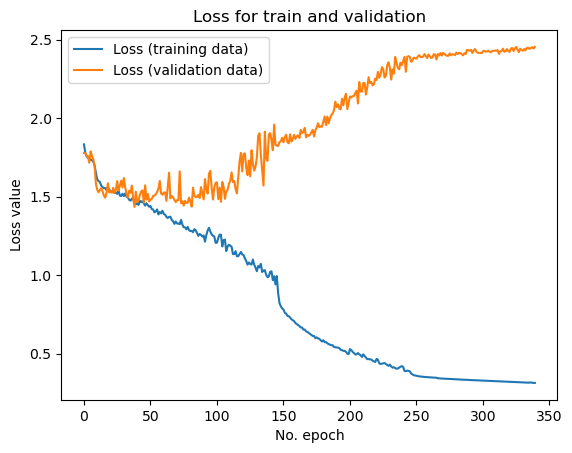

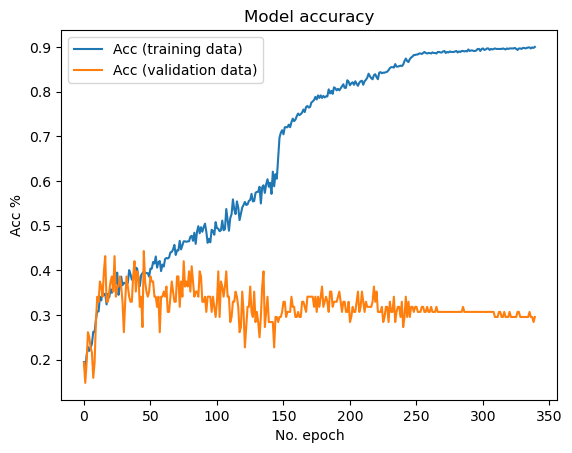

In [35]:
# Loss, Accuracy presentation

# Plot history: Loss
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for train and validation')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

#Plot history: Accuracy
plt.plot(history.history['categorical_accuracy'], label='Acc (training data)')
plt.plot(history.history['val_categorical_accuracy'], label='Acc (validation data)')
plt.title('Model accuracy')
plt.ylabel('Acc %')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [37]:
# Validation score
loss,acc = model.evaluate(x_val, y_val_class, verbose=2)

3/3 - 0s - 153ms/step - categorical_accuracy: 0.4432 - loss: 1.4624


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


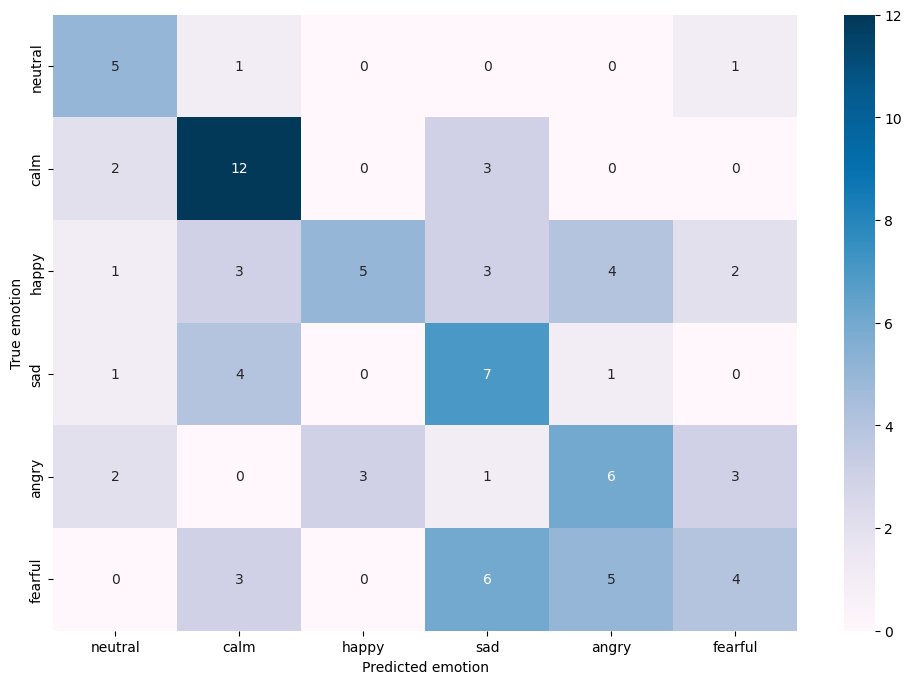

In [49]:


# Ensure y_val_class and y_pred_class are in label format
# y_val_class = np.argmax(y_val_class, axis=1)  # Uncomment if needed

predictions = model.predict(x_val)
y_pred_class = np.argmax(predictions, axis=1)

# Define all possible classes
all_classes = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

# Get unique classes present in y_val_class and y_pred_class
unique_classes = np.unique(np.concatenate((y_val_class, y_pred_class)))

# Create confusion matrix
cm = confusion_matrix(y_val_class, y_pred_class, labels=unique_classes)

# Create a dataframe with all classes
cm_df = pd.DataFrame(cm, index=[all_classes[i] for i in unique_classes],
                     columns=[all_classes[i] for i in unique_classes])

plt.figure(figsize=(12, 8))
ax = plt.axes()

sns.heatmap(cm_df, ax=ax, cmap='PuBu', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')
plt.show()


In [51]:
# Validation set prediction accuracy rates

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Validation set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

Validation set predicted emotions accuracy:
neutral : 0.7143
calm : 0.7059
happy : 0.2778
sad : 0.5385
angry : 0.4000
fearful : 0.2222


**DATA PREPROSSESSING, DATA VISUALIZATION, DATA IMPLEMENTATION FOR SINGLE FILE**


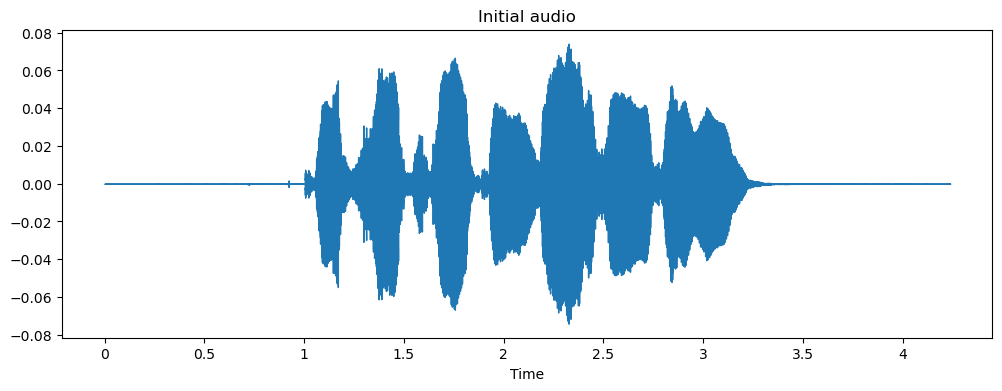

In [7]:
# Define file path for a single file.
path = r"C:\Users\rocky\OneDrive\Desktop\Desktop\INTERN\Audio_Song_Actors_01-24\Actor_01\03-02-01-01-01-01-01.wav"
x, sr = librosa.load(path, sr=None)

plt.figure(figsize=(12, 4))
librosa.display.waveshow(x, sr=sr)
plt.title('Initial audio')
plt.show()


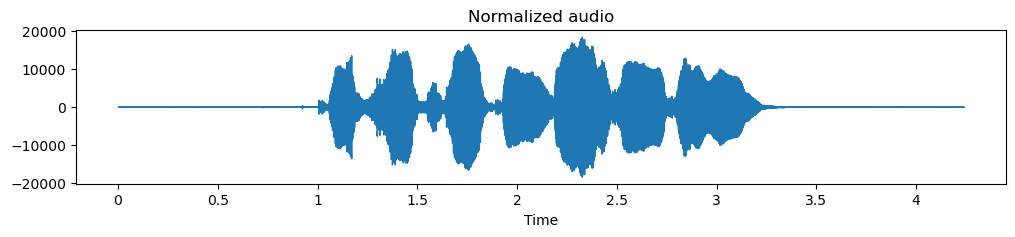

In [9]:
# 3. Trim silence in the beginning and end.
# Add ffmpeg to PATH for Jupyter Notebook session
os.environ["PATH"] += os.pathsep + r"C:\ffmpeg\bin"

# Load audio file
path = r"C:\Users\rocky\OneDrive\Desktop\Desktop\INTERN\Audio_Song_Actors_01-24\Actor_01\03-02-01-01-01-01-01.wav"
rawsound = AudioSegment.from_wav(path)

# Normalize the audio to +5.0 dBFS
normalizedsound = effects.normalize(rawsound, headroom=5.0)

# Convert normalized audio to numpy array
normal_x = np.array(normalizedsound.get_array_of_samples(), dtype='float32')

# Plotting the waveform of the normalized audio
plt.figure(figsize=(12, 2))
librosa.display.waveshow(normal_x, sr=normalizedsound.frame_rate)
plt.title('Normalized audio')
plt.show()




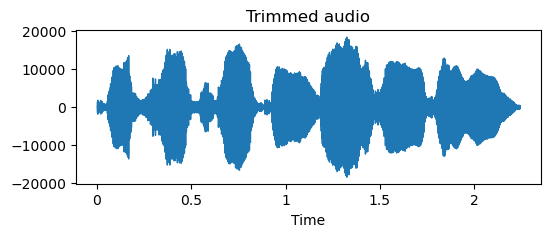

In [11]:
# Trim the silence
xt, index = librosa.effects.trim(normal_x, top_db=30)

# Plotting the trimmed audio
plt.figure(figsize=(6, 2))
librosa.display.waveshow(xt, sr=normalizedsound.frame_rate)
plt.title('Trimmed audio')
plt.show()
    
# Play the trimmed audio
ipd.display(ipd.Audio(data=xt, rate=normalizedsound.frame_rate))

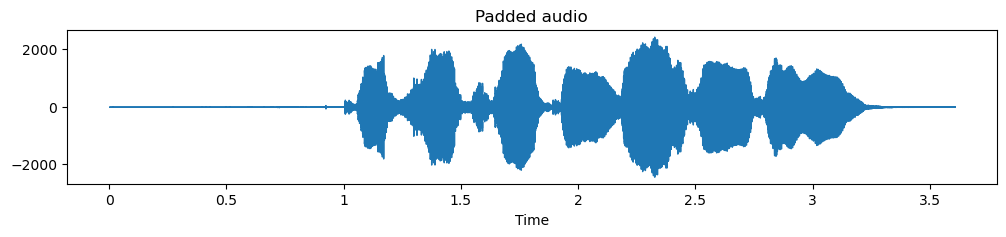

In [13]:


# Convert raw audio to numpy array
raw_x = np.array(rawsound.get_array_of_samples(), dtype='float32')
sr = rawsound.frame_rate

# Right-side padding for length equalization
max_length = 173056

if len(raw_x) < max_length:
    padded_x = np.pad(raw_x, (0, max_length - len(raw_x)), 'constant')
else:
    padded_x = raw_x[:max_length]

# Plotting the padded audio
plt.figure(figsize=(12, 2))
librosa.display.waveshow(padded_x, sr=sr)
plt.title('Padded audio')
plt.show()

# Play the padded audio
ipd.display(ipd.Audio(data=padded_x, rate=sr))


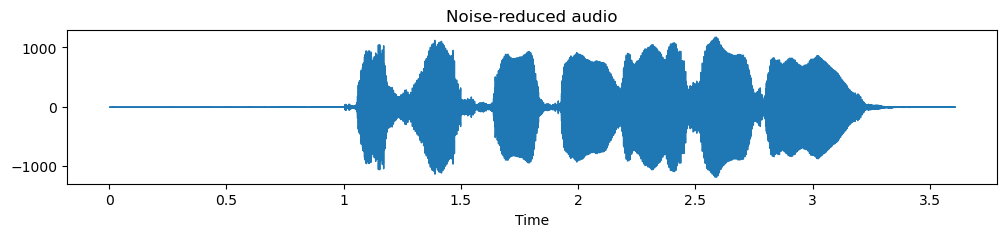

In [15]:


# Convert raw audio to numpy array
raw_x = np.array(rawsound.get_array_of_samples(), dtype='float32')
sr = rawsound.frame_rate

# Right-side padding for length equalization (assuming max_length is known)
max_length = 173056

if len(raw_x) < max_length:
    padded_x = np.pad(raw_x, (0, max_length - len(raw_x)), 'constant')
else:
    padded_x = raw_x[:max_length]

# Define a noise reduction function using an average filter
def reduce_noise_avg(audio, window_size=50):
    return uniform_filter1d(audio, size=window_size)

# Apply noise reduction
final_x = reduce_noise_avg(padded_x)

# Plotting the noise-reduced audio
plt.figure(figsize=(12, 2))
librosa.display.waveshow(final_x, sr=sr)
plt.title('Noise-reduced audio')
plt.show()

# Play the noise-reduced audio
ipd.display(ipd.Audio(data=final_x, rate=sr))


In [17]:


# Convert raw audio to numpy array
raw_x = np.array(rawsound.get_array_of_samples(), dtype='float32')
sr = rawsound.frame_rate

# Right-side padding for length equalization (assuming max_length is known)
max_length = 173056

if len(raw_x) < max_length:
    padded_x = np.pad(raw_x, (0, max_length - len(raw_x)), 'constant')
else:
    padded_x = raw_x[:max_length]

# Assuming 'final_x' is already obtained after noise reduction
final_x = padded_x

# Feature extraction parameters
frame_length = 2048
hop_length = 512

# Feature extraction
f1 = librosa.feature.rms(y=final_x, frame_length=frame_length, hop_length=hop_length)  # Energy - Root Mean Square (RMS)
print('Energy shape:', f1.shape)

f2 = librosa.feature.zero_crossing_rate(y=final_x, frame_length=frame_length, hop_length=hop_length)  # Zero Crossing Rate (ZCR)
print('ZCR shape:', f2.shape)

f3 = librosa.feature.mfcc(y=final_x, sr=sr, n_mfcc=13, hop_length=hop_length)  # MFCCs
print('MFCCs shape:', f3.shape)


Energy shape: (1, 339)
ZCR shape: (1, 339)
MFCCs shape: (13, 339)


In [1]:


# Load JSON and create model
with open(r'C:\Users\rocky\OneDrive\Desktop\Desktop\INTERN\Audio_Song_Actors_01-24\Actor_01\model8723.json', 'r') as json_file:
    model_json = json.load(json_file)
model = model_from_json(json.dumps(model_json))

# Load the weights file
weights_file = h5py.File(r'C:\Users\rocky\OneDrive\Desktop\Desktop\INTERN\Audio_Song_Actors_01-24\Actor_01\model8723_weights.h5', 'r')

# Function to set weights for each layer
def set_weights(layer, group):
    weights = [group[var][()] for var in group]
    layer.set_weights(weights)

# Assign weights manually to each layer
layer_dict = {layer.name: layer for layer in model.layers}

for key in weights_file.keys():
    if key in layer_dict:
        set_weights(layer_dict[key], weights_file[key])

# Close the weights file
weights_file.close()

# Verify the model structure
model.summary()

# Path to the uploaded audio file
audio_file_path = r'C:\Users\rocky\OneDrive\Desktop\Desktop\INTERN\Audio_Song_Actors_01-24\Actor_01\03-02-01-01-01-01-01.wav'

# Load the audio file and extract MFCC features
def extract_features(file_path):
    audio, sample_rate = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=15)
    # Ensure the MFCCs are of the shape (15, 476)
    mfccs = np.pad(mfccs, ((0, 0), (0, max(0, 476 - mfccs.shape[1]))), mode='constant')
    return mfccs.T[:476, :]  # Ensure it is exactly 476 frames

# Extract features from the audio file
features = extract_features(audio_file_path)

# Reshape the features to match the input shape of the model (batch_size, time_steps, features)
input_data = np.expand_dims(features, axis=0)

# Define the emotion labels (update this list based on your actual emotion labels)
emotion_labels = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

# Make multiple predictions to get a more stable output
num_predictions = 10
predictions = []

for _ in range(num_predictions):
    pred = model.predict(input_data)
    predicted_index = np.argmax(pred)
    predicted_emotion = emotion_labels[predicted_index]
    predictions.append(predicted_emotion)

# Get the most frequent prediction
most_common_prediction = Counter(predictions).most_common(1)[0][0]

# Output the predicted emotion
print(f"The predicted emotion is: {most_common_prediction}")


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 476, 64)             │          20,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 108,050 (422.07 KB)

 Trainable params: 54,024 (211.03 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 54,026 (211.04 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
The predicted emotion is: calm


**CALM**
